In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 12.1 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re
import transformers
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
# Load the dataset
from sklearn.datasets import fetch_20newsgroups
news_data = fetch_20newsgroups(subset='all', shuffle=True, random_state=42)

data = pd.DataFrame({'text': news_data['data'], 'category': news_data['target']})

In [4]:
data

,text,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4
...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1


In [5]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
# Preprocess the text data
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove numbers and special characters
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['text'] = data['text'].apply(preprocess)

In [8]:
# Split the dataset into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data['text'], data['category'], test_size=0.2, random_state=42)

In [9]:
# Load a pre-trained model
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
model = transformers.TFBertForSequenceClassification.from_pretrained('bert-base-uncased')


All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Fine-tune the pre-trained model on the classification task
from transformers import AutoTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

train_encodings = tokenizer(list(train_data.values), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(list(test_data.values), truncation=True, padding=True, max_length=512)

train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_labels))


In [16]:
model.fit(train_dataset.batch(8), epochs=2, batch_size=8)

Epoch 1/2
1885/1885 [==============================] - 1661s 852ms/step - loss: nan - accuracy: 0.0429
Epoch 2/2
1885/1885 [==============================] - 1601s 849ms/step - loss: nan - accuracy: 0.0430


In [45]:
# Evaluate the performance of the trained model on the test set
test_pred = model.predict(test_dataset.batch(32))
test_pred_labels = np.argmax(test_pred.logits, axis=-1)

118/118 [==============================] - 162s 1s/step


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(test_labels, test_pred_labels)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_pred_labels, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1_score}")

Accuracy: 0.04005305039787799
Precision: 0.0016042468461749538
Recall: 0.04005305039787799
F1-score: 0.0030849327263859096


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.04      1.00      0.08       151
           1       0.00      0.00      0.00       202
           2       0.00      0.00      0.00       195
           3       0.00      0.00      0.00       183
           4       0.00      0.00      0.00       205
           5       0.00      0.00      0.00       215
           6       0.00      0.00      0.00       193
           7       0.00      0.00      0.00       196
           8       0.00      0.00      0.00       168
           9       0.00      0.00      0.00       211
          10       0.00      0.00      0.00       198
          11       0.00      0.00      0.00       201
          12       0.00      0.00      0.00       202
          13       0.00      0.00      0.00       194
          14       0.00      0.00      0.00       189
          15       0.00      0.00      0.00       202
          16       0.00      0.00      0.00       188
          17       0.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


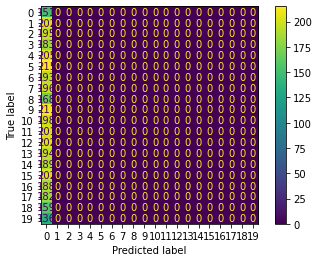

In [19]:
print(classification_report(test_labels, test_pred_labels))
cm = confusion_matrix(test_labels, test_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(test_labels))
disp.plot()